In [1]:
import scipy.constants as const
from arc import *
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.optimize import fmin
from scipy.optimize import brentq
from scipy.optimize import minimize
from scipy.optimize import curve_fit

# Light assisted two body loss rate

In [2]:
def trap_depth_gaussian(pol, P, wx, wy):
    """ trap depth for a focused gaussian beam
        pol: polarizability in units of Hz m^2/W
        P: power of the beam (W)
        wx: waist along x direction in m
        wy: waist along y direction in m
        return trap depth in Hz
    """
    I0_elliptical_xy= 2*P/ (np.pi* wx * wy) #multiply waists from um to cm such 
    U0_xy = - pol * I0_elliptical_xy/4 #in Hz. Divide by 4 because we used peak electric field in the calculation
                                    #of polarizability instead of rms.
    return U0_xy

mass_Rb = 87*const.u

### Sanity check: Tweezer
1.7 mW of 852nm focused on a round waist of 0.75 um, should yieald 1 mK trap depth

In [3]:
atom = Rubidium87()
calc = DynamicPolarizability(atom, atom.groundStateN, 0, 0.5)
calc.defineBasis(atom.groundStateN, atom.groundStateN+15)

alpha0_twz, alpha1_twz, alpha2_twz, core, dynamic, closestState = calc.getPolarizability(852e-9, units="SI", accountForStateLifetime=True)

tweez_polB_GS=2*alpha0_twz*1/(const.epsilon_0*const.speed_of_light) # units of Hz m^2/W. We consider only the scalar polarizability
print("Polarization of GS with 852nm = %.3e Hz m^2/W." % (tweez_polB_GS))
U0_tweezer = trap_depth_gaussian(tweez_polB_GS, 1.76e-3, 0.707e-6, 0.707e-6) #in Hz
print("Trap depth in uK: ", U0_tweezer*const.h/const.k*1e6)

Polarization of GS with 852nm = 3.884e-02 Hz m^2/W.
Trap depth in uK:  -1044.5188181367255


In [4]:
def trap_volume(T0, omega_ax, omega_rad, mass=mass_Rb):
    """
    T0 initial temperature in K
    omega_ax (rad) axial (radial) trap fequencies
    return in m^3
    """
    omega = (omega_ax * omega_rad**2)**(1/3)
    return (2*np.pi*const.k*T0/ (mass* omega**2))**(3/2)

def calc_beta(gamma,V):
    """
    gamma is the fitted two-body loss decay rate. 
    V trap volume
    return in SI units m^3/s
    """
    return gamma * 2* np.sqrt(2) * V

## Monte-Carlo simulation

In [5]:
def dq_two_body(beta_prime, N, dt):
    return beta_prime * N*(N-1)*dt/2

def dq_one_body(gamma, N, dt):
    return gamma * N *dt

def P1(U, T0, alpha, t):
    """ Survival probability of an atom due to heating. Assuming a harmonic trap and a Boltzmann energy distribution
    U: trap depth in J
    T0 initial temperature
    alpha: heating rate"""
    eta= U/ (const.k *(T0 + alpha*t))
    return 1- (1+ eta + 1/2 * eta**2) * np.exp(-eta)

def number_of_lost_atoms(key_name):
    if key_name == 'no_loss':
            return 0 # no loss
    elif key_name== 'one_loss':
            return 1 # one loss
    elif key_name== 'two_loss':
            return 2 # two loss

## Define beta' function

In [27]:
def betaPrimeFit(ts, beta_prime, initial_survival = 1,steady_state_survival = 0):
    init_surv = initial_survival
    ss_surv = steady_state_survival
    trajectories = 700
    n_point_per_time = 50
    print(ts)
    dt_step = ts[1] - ts[0]
    surv_sum_traj = np.zeros(len(ts))

    for j in np.arange(trajectories):
        N0 = 2  # Initial number of atoms
        surv_dts = np.zeros(len(ts))
        surv_dts[0] = N0

        for i in range(len(ts)):
            if i == 0:
                num_atoms_at_this_step = surv_dts[0]
            else:
                num_atoms_at_this_step = surv_dts[i - 1]

            P_two_body_loss = dq_two_body(beta_prime, num_atoms_at_this_step, dt_step)
            P_one_body_loss = 0  # Assuming no one-body loss for now

            prob_no_loss = (1 - P_one_body_loss) * (1 - P_two_body_loss)
            prob_one_loss = P_one_body_loss * (1 - P_two_body_loss)
            prob_two_loss = (1 - P_one_body_loss) * P_two_body_loss

            prob_dict = {'no_loss': prob_no_loss, 'one_loss': prob_one_loss, 'two_loss': prob_two_loss}

            # Define a probability order
            ordered_dict = sorted(prob_dict.items(), key=lambda x: x[1])

            # Choose which decay channel will happen using Monte Carlo
            p_rand = random.random()

            if p_rand < ordered_dict[0][1]:
                surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[0][0])
            elif ordered_dict[0][1] < p_rand < ordered_dict[1][1]:
                surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[1][0])
            else:
                surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[2][0])

        # In theory, this should be it. However, in our experiment, we apply a 2->1 collision if we still have two atoms at the end.
        for k in range(len(surv_dts)):
            if surv_dts[k] == 2:
                surv_dts[k] -= 1

        surv_sum_traj += surv_dts

    surv_average = surv_sum_traj / trajectories
    plt.plot(ts, ss_surv + (init_surv - ss_surv) * surv_average)
    return ss_surv + (init_surv - ss_surv) * surv_average  ## accounts for different initial and final surivival

In [43]:
def betaPrimeFit2(ts, beta_prime, initial_survival = 1,steady_state_survival = 0):
    init_surv = initial_survival
    ss_surv = steady_state_survival
    trajectories = 700
    n_point_per_time = 50
    # print(ts)
    # dt_step = ts[1] - ts[0]
    # surv_sum_traj = np.zeros(len(ts))
    # fin_surv = np.zeros(len(ts))
    fin_surv=[]
    
    for t in ts:
        times_x= np.linspace(0, t, n_point_per_time)
        dt_step = times_x[1] - times_x[0]
        surv_sum_traj = np.zeros(len(times_x))

        for j in np.arange(trajectories):
            N0 = 2  # Initial number of atoms
            surv_dts = np.zeros(len(times_x))
            surv_dts[0] = N0

            for i in range(len(times_x)):
                if i == 0:
                    num_atoms_at_this_step = surv_dts[0]
                else:
                    num_atoms_at_this_step = surv_dts[i - 1]

                P_two_body_loss = dq_two_body(beta_prime, num_atoms_at_this_step, dt_step)
                P_one_body_loss = 0  # Assuming no one-body loss for now

                prob_no_loss = (1 - P_one_body_loss) * (1 - P_two_body_loss)
                prob_one_loss = P_one_body_loss * (1 - P_two_body_loss)
                prob_two_loss = (1 - P_one_body_loss) * P_two_body_loss

                prob_dict = {'no_loss': prob_no_loss, 'one_loss': prob_one_loss, 'two_loss': prob_two_loss}

                # Define a probability order
                ordered_dict = sorted(prob_dict.items(), key=lambda x: x[1])

                # Choose which decay channel will happen using Monte Carlo
                p_rand = random.random()

                if p_rand < ordered_dict[0][1]:
                    surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[0][0])
                elif ordered_dict[0][1] < p_rand < ordered_dict[1][1]:
                    surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[1][0])
                else:
                    surv_dts[i] = num_atoms_at_this_step - number_of_lost_atoms(ordered_dict[2][0])

            # In theory, this should be it. However, in our experiment, we apply a 2->1 collision if we still have two atoms at the end.
            for k in range(len(surv_dts)):
                if surv_dts[k] == 2:
                    surv_dts[k] -= 1

            surv_sum_traj += surv_dts

        surv_average = surv_sum_traj / trajectories
        fin_surv.append(ss_surv + (init_surv - ss_surv) * surv_average[-1])
    # plt.plot(ts, fin_surv)
    return fin_surv ## accounts for different initial and final surivival

200.0


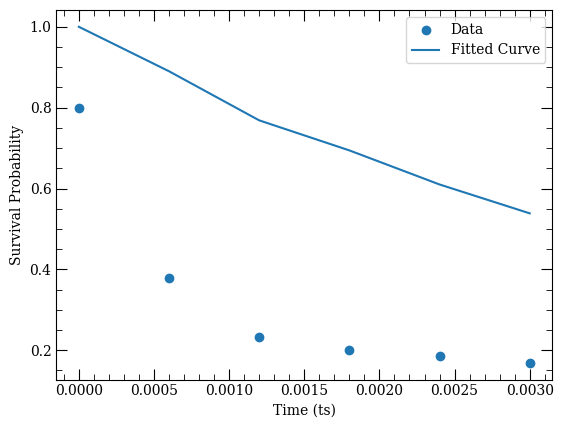

Optimized Parameter:
Optimal BetaPrime: 200.0


In [45]:
# Define a residual function
def residual(x_data, betaPrime):
    model_data = betaPrimeFit2(x_data, betaPrime)
    return y_data - model_data

# Simulated data
x_data = np.array([1.01e-07, 0.0006, 0.0012, 0.0018, 0.0024, 0.003])
y_data = np.array([0.8, 0.37974684, 0.23376623, 0.2, 0.18518519, 0.16901408])

# Initial guess for the parameter
initial_guess = (20e1)  # Replace with an appropriate initial value

# Fit the model to the data using curve_fit
params, covariance = curve_fit(residual, x_data, y_data, p0=initial_guess)

# Extract the optimized parameter
optimal_betaPrime = params[0]
print(optimal_betaPrime)
# Generate the fitted curve
fit_curve = betaPrimeFit2(x_data, optimal_betaPrime)

# Plot the data and fitted curve
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, fit_curve, label='Fitted Curve')
plt.legend()
plt.xlabel('Time (ts)')
plt.ylabel('Survival Probability')
plt.show()

print("Optimized Parameter:")
print("Optimal BetaPrime:", optimal_betaPrime)

## Brute force fitting

In [52]:
# Used for the fitting:
def residual(betaPrime, x_pts, data, uncertainties):
    model = betaPrimeFit2(x_pts, betaPrime)
    return (((model-data)/uncertainties)**2).sum()

In [58]:
def get_smoothed_residual_f(x, residual):
    _sg = savgol_filter(residual, window_length=7, polyorder=3) # window size 51, polynomial order 3
    _f = interp1d(x, _sg, kind='cubic')
    return _f

In [59]:
def get_minimum(_f, x0):
    _xmin,_fmin, _,_,warnflag = fmin(_f, 
        x0, disp=False,full_output=True)
    if warnflag:
        print(f"{warnflag:d} ---  1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.")
    return _xmin, _fmin

In [60]:
def get_root(_f, y0, xbound0, xbound1):
    _f_offset = lambda x : (_f(x) - y0)
    root = brentq(_f_offset, xbound0, xbound1, disp=False)
    return root
    # return get_minimum(_f=_f_offset, x0=x0)

In [61]:
def decay_exponential(x, A, k, C):
    return A * np.exp(-k * x) + C


typical collision data sets have 6 or 8 points

In [26]:
# betaPrimeFit(x_data, 5e3, initial_survival = 1,steady_state_survival = 0)
x_data

array([0.        , 0.00042857, 0.00085714, 0.00128571, 0.00171429,
       0.00214286, 0.00257143, 0.003     ])

In [48]:
x_data = np.linspace(0,3e-3,8)
y_data = decay_exponential(x_data,1, 1.8e3,0)
errs = [0.1 for _ in range(8)]

surv = y_data
surv_unc = errs
x_axis = x_data
rranges = (slice(1e3, 2e3, 0.1e3),)

out, fout, grid, fgrid = optimize.brute(residual,rranges,
    args=(x_axis, surv, surv_unc),full_output=True,finish='leastsq')

these should all be starting at 1 which is the problem, and the resulting minimization is not accurate. 

In [49]:
grid.shape

(10,)

Text(0.5, 1.0, 'survival')

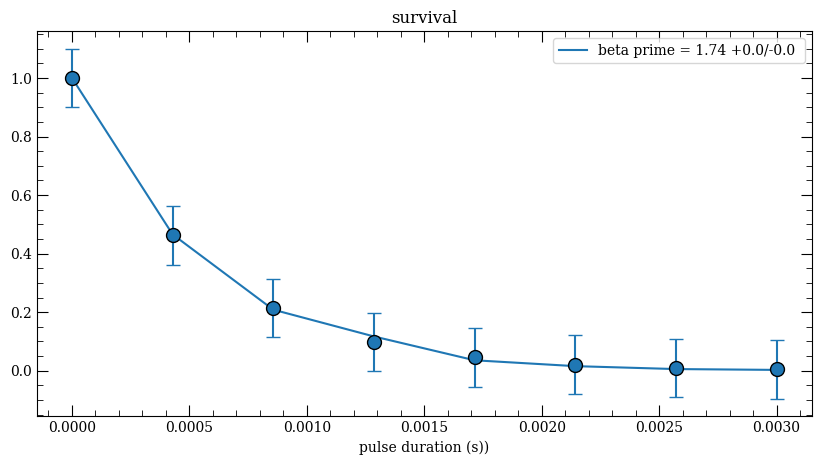

In [62]:
f_loss_smooth = get_smoothed_residual_f(grid, fgrid)
grid_min, loss_min = get_minimum(f_loss_smooth, out)
grid_min_err_low = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid.min(), xbound1=grid_min)
grid_min_err_high = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid_min, xbound1=grid.max())
low_err=grid_min[0]-grid_min_err_low # those turns out to be array with only one element
high_err=grid_min_err_high-grid_min[0]
popt_min=grid_min[0]
loss_mins=loss_min
# print(grid_min, grid_min_err_low, grid_min_err_high, loss_min)
fig,ax = plt.subplots(1, figsize=[10,5])
ax = [ax]

times= np.linspace(0, 3e-3, 50)
ax[0].plot(x_data, betaPrimeFit2(x_data,popt_min), 
        label= f"beta prime = {popt_min*1e-3:.2f} +{high_err*1e-3:.1f}/-{low_err*1e-3:.1f} ")
ax[0].errorbar(x_data,y_data, yerr=errs,ls='none',ecolor='tab:blue',marker = 'o',markersize = 10,markerfacecolor='tab:blue',markeredgecolor='k',capsize=5)
ax[0].legend()
ax[0].set_xlabel(r"pulse duration (s))")
ax[0].set_title("survival")

If I increase the data points to 100 it resolves the problem, but I need it to work with 6-8 data points

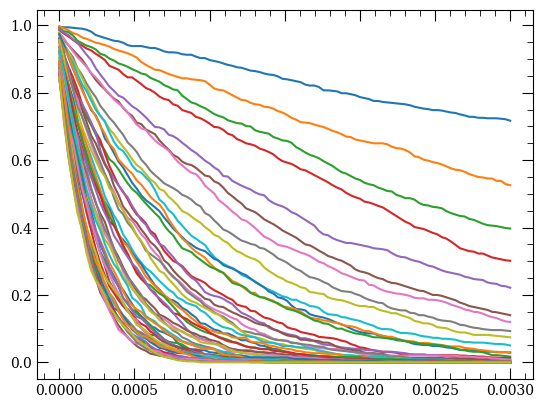

In [15]:
x_data = np.linspace(0,3e-3,100)
y_data = decay_exponential(x_data,1,1.8e3,0)
errs = [0.1 for _ in range(100)]

surv = y_data
surv_unc = errs
x_axis = x_data
rranges = (slice(.1e3, 5e3, 0.1e3),)

out, fout, grid, fgrid = optimize.brute(residual,rranges,
    args=(x_axis, surv, surv_unc),full_output=True,finish='leastsq')

In [16]:
f_loss_smooth = get_smoothed_residual_f(grid, fgrid)
grid_min, loss_min = get_minimum(f_loss_smooth, out)
grid_min_err_low = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid.min(), xbound1=grid_min)
grid_min_err_high = get_root(f_loss_smooth, y0=loss_min*1.1, xbound0=grid_min, xbound1=grid.max())
low_err=grid_min[0]-grid_min_err_low # those turns out to be array with only one element
high_err=grid_min_err_high-grid_min[0]
popt_min=grid_min[0]
loss_mins=loss_min
# print(grid_min, grid_min_err_low, grid_min_err_high, loss_min)
fig,ax = plt.subplots(1, figsize=[10,5])
ax = [ax]

times= np.linspace(0, 3e-3, 50)
ax[0].plot(times, betaPrimeFit(times,popt_min), 
        label= f"beta prime = {popt_min*1e-3:.2f} +{high_err*1e-3:.1f}/-{low_err*1e-3:.1f} ")
ax[0].errorbar(x_data,y_data, yerr=errs,ls='none',ecolor='tab:blue',marker = 'o',markersize = 10,markerfacecolor='tab:blue',markeredgecolor='k',capsize=5)
ax[0].legend()
ax[0].set_xlabel(r"pulse duration (s))")
ax[0].set_title("survival")

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.